# Project

- Predicting Cash Rate

- Methods: 
    - Exponential Weighting 
    - Logistic Regression
    - ARIMA


In [702]:
# !pip install pmdarima
# import ssl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression, LassoCV, ElasticNetCV, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report, confusion_matrix, r2_score
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
import matplotlib.dates as mdates
import statsmodels.formula.api as smf
from statsmodels.genmod.families import Binomial
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import norm
import itertools
from sklearn.metrics import mean_squared_error, r2_score
from pmdarima import ARIMA
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

## Data Cleaning

In [613]:
# ssl._create_default_https_context = ssl._create_unverified_context
# url = 'https://raw.githubusercontent.com/AS2357/ADA-dataset/refs/heads/project/project%20data%20updated.csv'
df = pd.read_excel('/Users/apple/Downloads/Untitled spreadsheet.xlsx', index_col='time', parse_dates=True)
df.drop(columns=['unemployment_rate'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 306 entries, 1999-03-01 to 2024-08-01
Data columns (total 28 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Cash_rate                                  306 non-null    float64
 1   inflation_rate                             306 non-null    float64
 2   CPI                                        306 non-null    float64
 3   lag4 cash rate                             306 non-null    float64
 4   lag3 cash rate                             306 non-null    float64
 5   lag2 cash rate                             306 non-null    float64
 6   lag1 cash rate                             306 non-null    float64
 7   hourly_wage_growth                         306 non-null    float64
 8   Bank_Prime_Loan_rate                       306 non-null    float64
 9    labor_market_condition_index              306 non-null    float64
 10  USD-AUD

In [614]:
# Split the data into training and testing sets
X = df.drop(columns=['Cash_rate', 'CPI'])
y = df['Cash_rate']

def round_to_nearest_quarter(x):
    return round((x - 0.15) * 4) / 4 + 0.15

# y = y.apply(round_to_nearest_quarter)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (244, 26)
X_test shape: (62, 26)
y_train shape: (244,)
y_test shape: (62,)


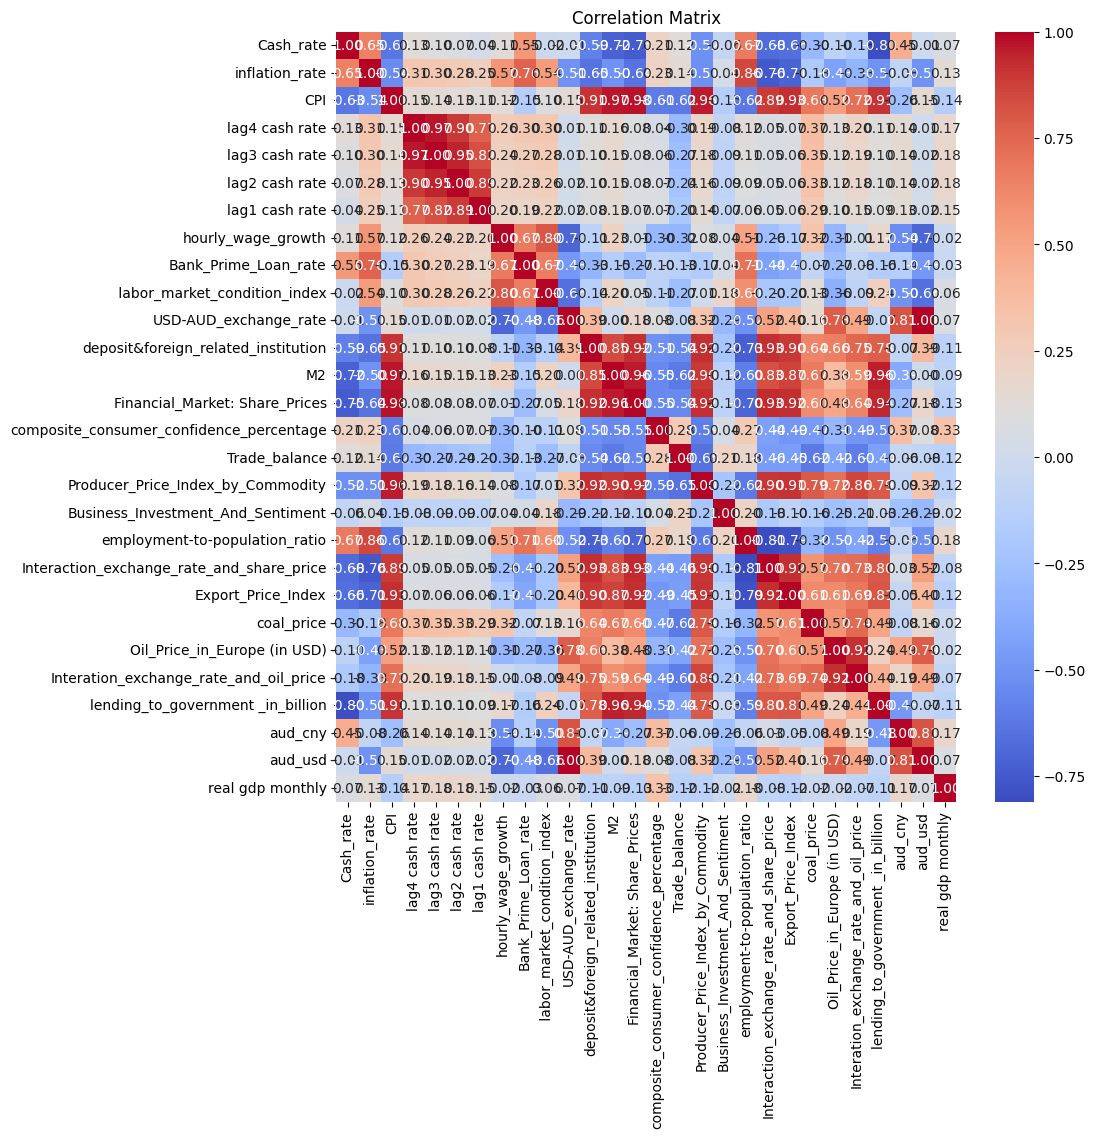

In [615]:
# correlation matrix
corr = df.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

## Exponential Weighting

### Intuition

- Any relevant data from 20 years ago unlikely to have much impact on today's data/ cash rate. So, taking different weighting based on timing, that is, less weight on those data from long times ago.

- Started with find the best span using MSE as criteria.
- Then, apply to the testing data

In [616]:
span_values = range(2, 21) 
best_span = None
best_score = float('inf')

for span in span_values:
    X_train_ewm = X_train.ewm(span=span, adjust=False).mean()
    y_train_ewm = y_train.ewm(span=span, adjust=False).mean()

    X_test_ewm = X_test.ewm(span=span, adjust=False).mean()
    y_test_ewm = y_test.ewm(span=span, adjust=False).mean()

    X_train_ewm.fillna(X_train_ewm.mean(), inplace=True)
    y_train_ewm.fillna(y_train_ewm.mean(), inplace=True)
    X_test_ewm.fillna(X_test_ewm.mean(), inplace=True)
    y_test_ewm.fillna(y_test_ewm.mean(), inplace=True)

    model = LinearRegression()
    model.fit(X_train_ewm, y_train_ewm)

    y_pred = model.predict(X_test_ewm)

    score = mean_squared_error(y_test_ewm, y_pred)

    if score < best_score:
        best_score = score
        best_span = span

print(f"Best span: {best_span} with MSE: {best_score}")

Best span: 12 with MSE: 0.02911404733749322


In [617]:
best_span = 10

X_train_ewm = X_train.ewm(span=best_span, adjust=False).mean()
y_train_ewm = y_train.ewm(span=best_span, adjust=False).mean()

# Apply exponential weighting to the testing data
X_test_ewm = X_test.ewm(span=best_span, adjust=False).mean()
y_test_ewm = y_test.ewm(span=best_span, adjust=False).mean()

# Train a linear regression model
model_ew = LinearRegression()
model_ew.fit(X_train_ewm, y_train_ewm)

# Predict on the test set
y_pred = model_ew.predict(X_test_ewm)

# Evaluate the model
mse = mean_squared_error(y_test_ewm, y_pred)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 0.029520340313765155


### Plot

In [618]:
# Apply exponential weighting to the entire dataset
X_ewm = X.ewm(span=best_span, adjust=False).mean()
y_ewm = y.ewm(span=best_span, adjust=False).mean()

y_pred_all = model.predict(X_ewm)

In [619]:
# plt.figure(figsize=(10, 6))
# plt.plot(df['time'], y_ewm, label='Actual', alpha=0.6, linewidth=2)
# plt.plot(df['time'], y_pred_all, label='Predicted', alpha=0.6, linewidth=2)

# # Format the x-axis to show only the year
# plt.gca().xaxis.set_major_locator(mdates.YearLocator())
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.title('Actual vs Predicted Data Across All Time')
# plt.legend()

# # Rotate date labels for better readability
# plt.gcf().autofmt_xdate(rotation=45, ha='right')

# plt.show()

### Prediction: exponential weighting

In [620]:
# ewma = df['cash rate target'].ewm(span=best_span, adjust=False).mean()
# h = 5
# last_ewma = ewma.iloc[-1]

# future_dates = pd.date_range(start=df['time'].iloc[-1], periods=h+1, freq='M')
# future_predictions = pd.DataFrame(index=future_dates, columns=['EWMA_Prediction'])
# future_predictions['EWMA_Prediction'] = last_ewma
# combined_data = pd.concat([df, future_predictions])

# # Display the combined data with predictions
# print(combined_data['EWMA_Prediction'].tail(10))

The result gives the same prediction for all time periods after the observation data, as this is method could only predict on periods where have observation on independent variables. However, the results gives 4.219169%, where closed to 4.35%.

## Logistic Regression

### Intuition

- Setting three events:
  - Target cash rate increase (+1)
  - Target cash rate decrease (-1)
  - Target cash rate remain the same (0)

- Generally, the target cash rate would increases or decreases for 0.25% each time. So, setting 0.25% as an increment.

In [621]:
df['target'] = df['Cash_rate'].diff().apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
df.dropna(inplace=True)

df['lag1'] = df['Cash_rate'].shift(1)
df['lag2'] = df['Cash_rate'].shift(2)
df.dropna(inplace=True)

# Define features and target
X = df[['lag1', 'lag2']]
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [622]:
model = LogisticRegression(multi_class='ovr')
model.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(multi_class='ovr')

In [623]:
y_pred = model.predict(X_test)
y_pred_all = model.predict(X)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Accuracy: 0.576271186440678
Mean Squared Error: 0.423728813559322


In [752]:
# In-sample 
y_train_pred = model.predict(X_train)

# Out-of-sample 
y_test_pred = model.predict(X_test)

r2_in_sample = r2_score(y_train, y_train_pred)
mse_in_sample = mean_squared_error(y_train, y_train_pred)

r2_out_of_sample = r2_score(y_test, y_test_pred)
mse_out_of_sample = mean_squared_error(y_test, y_test_pred)
accuracy_s = accuracy_score(y_test, y_test_pred)
print(f'Accuracy: {accuracy_s}')

print(f'In-Sample R² Score: {r2_in_sample}')
print(f'In-Sample Mean Squared Error: {mse_in_sample}')
print(f'Out-of-Sample R² Score: {r2_out_of_sample}')
print(f'Out-of-Sample Mean Squared Error: {mse_out_of_sample}')

Unexpected exception formatting exception. Falling back to standard exception


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/42/yhmnwch51ys3m0q7ng_glw_h0000gn/T/ipykernel_56876/3445163908.py", line 12, in <module>
    accuracy_s = accuracy_score(y_test, y_test_pred)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*

As shown from the mse and r squared, this might not be the optimal model. While I'll still process to forecasting.

In [625]:
last_lag1 = df['lag1'].iloc[-1]
last_lag2 = df['lag2'].iloc[-1]

future_predictions = []
for _ in range(5):
    new_data = pd.DataFrame({'lag1': [last_lag1], 'lag2': [last_lag2]})
    prediction = model.predict(new_data)[0]
    future_predictions.append(prediction)
    
    # Update lags for the next prediction
    last_lag2 = last_lag1
    last_lag1 = prediction

print(f'5 Steps Ahead Predictions: {future_predictions}')

5 Steps Ahead Predictions: [0, -1, -1, 0, 0]


As the first step ahead forecast is 0, meaning that the target interest rate remains the same this month, which remains at 4.35%.

### Plot: Confusion Matrix

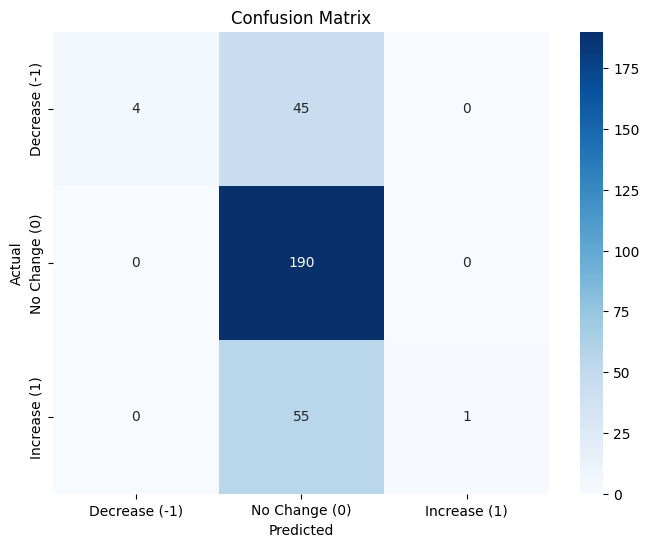

In [626]:
conf_matrix = confusion_matrix(y, y_pred_all, labels=[-1, 0, 1])

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Decrease (-1)', 'No Change (0)', 'Increase (1)'], yticklabels=['Decrease (-1)', 'No Change (0)', 'Increase (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

It looks like most prediction results are no change, which consists more than 90% of prediction results. In fact, the Reserve Bank Board don't adjust the cash rate every month or that often. It seems like a valid prediction.

In [627]:
future_dates = pd.date_range(start='2024/08/01', periods=6, freq='M')[1:]
future_df = pd.DataFrame({'Cash_rate': future_predictions}, index=future_dates)

# def round_to_nearest_quarter(x):
#     return round((x - 0.15) * 4) / 4 + 0.15

future_df['Cash_rate'] = df['Cash_rate'].apply(round_to_nearest_quarter).iloc[-1] + future_df['Cash_rate'].cumsum()
print(future_df['Cash_rate'])

2024-09-30    4.4
2024-10-31    3.4
2024-11-30    2.4
2024-12-31    2.4
2025-01-31    2.4
Freq: M, Name: Cash_rate, dtype: float64


The target cash rate in September predicted as 4.35%.

In [628]:
min_length = min(len(y), len(y_pred_all))
y = y[:min_length]
y_pred_all = y_pred_all[:min_length]

data = {
    'cash rate target': y,
    'predicted_cash_rate': y_pred_all
}
all_predictions = pd.DataFrame(data)

all_predictions['predicted_cash_rate'] = all_predictions['predicted_cash_rate'].fillna(method='ffill')

### try use categorical data

- Logistic regression

In [660]:
X = df.drop(columns=['Cash_rate', 'CPI'])
y = df['Cash_rate']

def zhenmafan(values):
    categorical = [0]  # The first value has no previous value to compare with
    for i in range(1, len(values)):
        if values[i] > values[i - 1]:
            categorical.append(1)
        elif values[i] < values[i - 1]:
            categorical.append(-1)
        else:
            categorical.append(0)
    return np.array(categorical)

y_categorical = zhenmafan(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# Step 4: Train logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [665]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# In-sample predictions
y_train_pred = model.predict(X_train)
# Out-of-sample predictions
y_test_pred = model.predict(X_test)

# In-sample evaluation
train_accuracy = accuracy_score(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)

# Out-of-sample evaluation
test_accuracy = accuracy_score(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

# Confusion matrix for out-of-sample predictions
conf_matrix = confusion_matrix(y_test, y_test_pred)

print(f"In-sample accuracy: {train_accuracy}")
print(f"In-sample R-squared: {train_r2}")
print(f"In-sample MSE: {train_mse}")

print(f"Out-of-sample accuracy: {test_accuracy}")
print(f"Out-of-sample R-squared: {test_r2}")
print(f"Out-of-sample MSE: {test_mse}")


In-sample accuracy: 0.6623931623931624
In-sample R-squared: -0.17700316885468514
In-sample MSE: 0.42735042735042733
Out-of-sample accuracy: 0.7457627118644068
Out-of-sample R-squared: 0.08762886597938169
Out-of-sample MSE: 0.3050847457627119


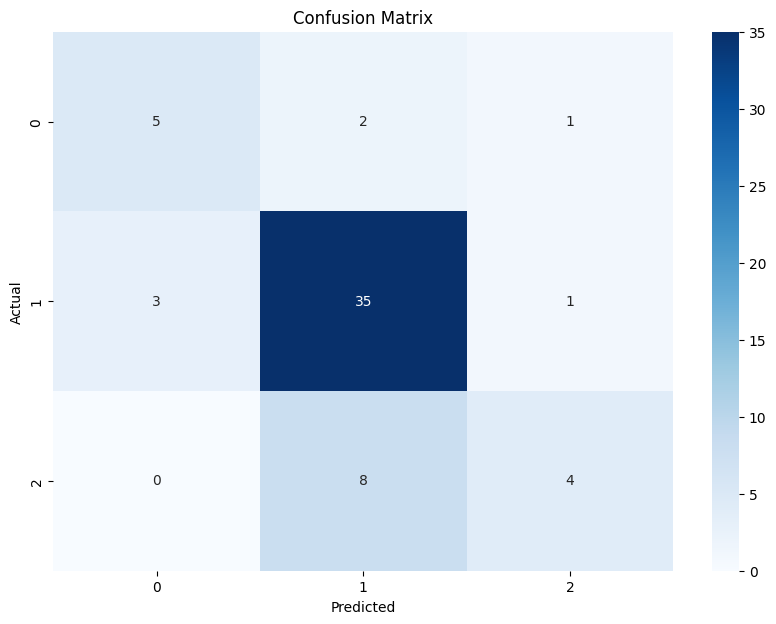

In [666]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [668]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
import numpy as np

# Assuming df is already defined and contains the data

# Prepare the data
X = df.drop(columns=['Cash_rate', 'CPI'])
y = pd.cut(df['Cash_rate'], bins=3, labels=[0, 1, 2])  # Adjust the number of bins and labels as needed

# Ensure the index is datetime if not already
X.index = pd.to_datetime(X.index)

# Create rolling window for time series prediction
window_size = 5
X_train, y_train = [], []
for i in range(len(X) - window_size):
    X_train.append(X.iloc[i:i + window_size].values.flatten())
    y_train.append(y.iloc[i + window_size])

X_train = np.array(X_train)
y_train = np.array(y_train)

# Train logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Make predictions for 5 steps ahead
X_test = X.iloc[-window_size:].values.flatten().reshape(1, -1)
y_pred = []
for _ in range(5):
    pred = model.predict(X_test)[0]
    y_pred.append(pred)
    X_test = np.roll(X_test, -1)
    X_test[0, -1] = pred

# Print the predictions
print("5-step ahead predictions:", y_pred)

5-step ahead predictions: [1, 2, 2, 2, 1]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


1 for September, means remaining the same.

### try with different max_iter

In [671]:
X = df.drop(columns=['Cash_rate', 'CPI'])
y = pd.cut(df['Cash_rate'], bins=3, labels=[0, 1, 2])  # Adjust the number of bins and labels as needed
X.index = pd.to_datetime(X.index)

window_size = 5
X_train, y_train = [], []
for i in range(len(X) - window_size):
    X_train.append(X.iloc[i:i + window_size].values.flatten())
    y_train.append(y.iloc[i + window_size])

X_train = np.array(X_train)
y_train = np.array(y_train)

# Split the data into training and testing sets
split_index = int(len(X_train) * 0.8)
X_train_split, X_test_split = X_train[:split_index], X_train[split_index:]
y_train_split, y_test_split = y_train[:split_index], y_train[split_index:]


In [680]:
max_iter_values = [200, 250, 300, 350, 400, 500]
best_accuracy = 0
best_max_iter = 200

for max_iter in max_iter_values:
    model = LogisticRegression(max_iter=max_iter)
    model.fit(X_train_split, y_train_split)
    y_test_pred = model.predict(X_test_split)
    accuracy = accuracy_score(y_test_split, y_test_pred)
    print(f"max_iter: {max_iter}, accuracy: {accuracy}")
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_max_iter = max_iter
        



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

max_iter: 200, accuracy: 0.6896551724137931
max_iter: 250, accuracy: 0.7586206896551724
max_iter: 300, accuracy: 0.7586206896551724
max_iter: 350, accuracy: 0.7586206896551724
max_iter: 400, accuracy: 0.7586206896551724
max_iter: 500, accuracy: 0.7586206896551724


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [681]:
print(f"Optimal max_iter: {best_max_iter} with accuracy: {best_accuracy}")

Optimal max_iter: 250 with accuracy: 0.7586206896551724


In [682]:
model = LogisticRegression(max_iter=best_max_iter)
model.fit(X_train, y_train)

X_test = X.iloc[-window_size:].values.flatten().reshape(1, -1)
y_pred = []
for _ in range(5):
    pred = model.predict(X_test)[0]
    y_pred.append(pred)
    X_test = np.roll(X_test, -1)
    X_test[0, -1] = pred
    
# Print the predictions
print("5-step ahead predictions:", y_pred)

5-step ahead predictions: [0, 1, 1, 2, 0]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## different method of splid data

In [683]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

In [753]:
X = df.drop(columns=['Cash_rate', 'CPI'])
y = pd.cut(df['Cash_rate'], bins=3, labels=[0, 1, 2])  # Adjust the number of bins and labels as needed
X.index = pd.to_datetime(X.index)

window_size = 6
X_windowed, y_windowed = [], []
for i in range(len(X) - window_size):
    X_windowed.append(X.iloc[i:i + window_size].values.flatten())
    y_windowed.append(y.iloc[i + window_size])

X_windowed = np.array(X_windowed)
y_windowed = np.array(y_windowed)

# Use TimeSeriesSplit to split the data
tscv = TimeSeriesSplit(n_splits=10)
best_accuracy = 0
best_max_iter = 100

max_iter_values = [100, 200, 300, 400, 500, 1000, 2000]
last_train_index, last_test_index = None, None

for train_index, test_index in tscv.split(X_windowed):
    X_train_split, X_test_split = X_windowed[train_index], X_windowed[test_index]
    y_train_split, y_test_split = y_windowed[train_index], y_windowed[test_index]
    
    for max_iter in max_iter_values:
        model = LogisticRegression(max_iter=max_iter)
        model.fit(X_train_split, y_train_split)
        y_test_pred = model.predict(X_test_split)
        accuracy = accuracy_score(y_test_split, y_test_pred)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_max_iter = max_iter
    last_train_index, last_test_index = train_index, test_index

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/42/yhmnwch51ys3m0q7ng_glw_h0000gn/T/ipykernel_56876/2752604176.py", line 28, in <module>
    model.fit(X_train_split, y_train_split)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1350, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.

In [723]:
print(f"Optimal max_iter: {best_max_iter} with accuracy: {best_accuracy}")

Optimal max_iter: 2000 with accuracy: 1.0


In [724]:
# Train the model with the optimal max_iter on the entire dataset
model = LogisticRegression(max_iter=best_max_iter)
model.fit(X_windowed, y_windowed)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=2000)

In [725]:
# In-sample predictions
y_train_pred = model.predict(X_windowed)

# Use the last split from TimeSeriesSplit for out-of-sample predictions
X_train_split, X_test_split = X_windowed[last_train_index], X_windowed[last_test_index]
y_train_split, y_test_split = y_windowed[last_train_index], y_windowed[last_test_index]
y_test_pred = model.predict(X_test_split)

# Calculate and print in-sample accuracy
in_sample_accuracy = accuracy_score(y_windowed, y_train_pred)
print(f"In-sample accuracy: {in_sample_accuracy}")

# Calculate and print out-of-sample accuracy
out_of_sample_accuracy = accuracy_score(y_test_split, y_test_pred)
print(f"Out-of-sample accuracy: {out_of_sample_accuracy}")

In-sample accuracy: 1.0
Out-of-sample accuracy: 1.0


In [726]:
# Make predictions for 5 steps ahead
X_test_window = X.iloc[-window_size:].values.flatten().reshape(1, -1)
y_pred_5_steps = []
for _ in range(5):
    pred = model.predict(X_test_window)[0]
    y_pred_5_steps.append(pred)
    X_test_window = np.roll(X_test_window, -1)
    X_test_window[0, -1] = pred

print("5-step ahead predictions:", y_pred_5_steps)

5-step ahead predictions: [1, 1, 2, 2, 1]


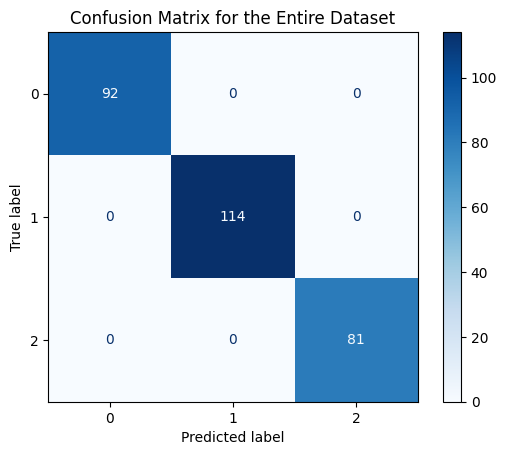

In [727]:
conf_matrix = confusion_matrix(y_windowed, y_train_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1, 2])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for the Entire Dataset")
plt.show()

## ARIMA

In [728]:
model = auto_arima(df['Cash_rate'], seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
print(model.summary())

model_fit = model.fit(df['Cash_rate'])

# Forecast future values
forecast_steps = 5
forecast = model_fit.predict(n_periods=forecast_steps)

forecast = forecast.apply(round_to_nearest_quarter)
forecast_index = pd.date_range(start='2024-08-01', periods=forecast_steps + 1, freq='M')[1:]
forecast_df = pd.DataFrame({'Cash_rate': forecast}, index=forecast_index)

data = {
    'date': forecast_index,
    'predicted_cash_rate': forecast
}
all_predictions = pd.DataFrame(data)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-343.594, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-216.223, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-332.045, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-285.124, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-218.197, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-345.603, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-316.503, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-346.182, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-345.496, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-347.138, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-345.575, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-343.731, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-349.138, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-334.044, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]          

In [729]:
print(all_predictions[['date', 'predicted_cash_rate']])

                 date  predicted_cash_rate
2023-12-01 2024-09-30                 4.40
2024-01-01 2024-10-31                 4.40
2024-02-01 2024-11-30                 4.40
2024-03-01 2024-12-31                 4.65
2024-04-01 2025-01-31                 4.65


Predicted target cash rate in September is 4.35%, as 4.40 close to 4.35.

In [730]:
df['predicted_cash_rate'] = model_fit.predict_in_sample()

mse = mean_squared_error(df['Cash_rate'], df['predicted_cash_rate'])
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.09426625229276442


In [731]:
from sklearn.metrics import mean_squared_error, r2_score
from pmdarima import ARIMA

# Fit the ARIMA(2,1,0) model on the training set
model = ARIMA(order=(2, 1, 0))
model_fit = model.fit(y_train)

# In-sample prediction
y_train_pred = model_fit.predict_in_sample()

# Calculate in-sample MSE and R-squared
in_sample_mse = mean_squared_error(y_train, y_train_pred)
in_sample_r2 = r2_score(y_train, y_train_pred)
print(f'In-sample Mean Squared Error: {in_sample_mse}')
print(f'In-sample R-squared: {in_sample_r2}')

In-sample Mean Squared Error: 0.03128642170772797
In-sample R-squared: 0.9481120338693556


In [732]:
# Out-of-sample 
y_test_pred = model_fit.predict(n_periods=len(y_test))

out_sample_mse = mean_squared_error(y_test, y_test_pred)
out_sample_r2 = r2_score(y_test, y_test_pred)
print(f'Out-of-sample Mean Squared Error: {out_sample_mse}')
print(f'Out-of-sample R-squared: {out_sample_r2}')

Out-of-sample Mean Squared Error: 1.009690290677523
Out-of-sample R-squared: -2.0195291252993615


### plot

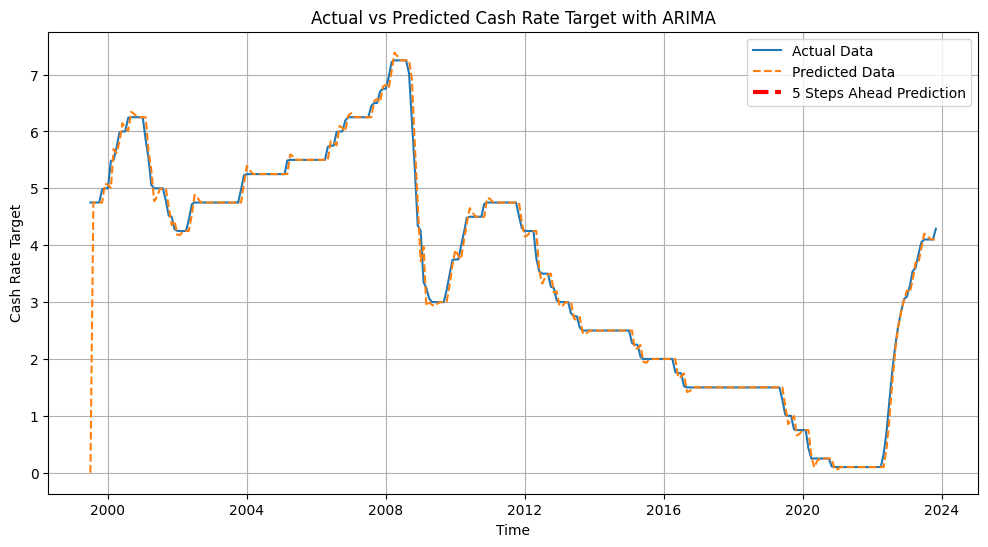

In [733]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Cash_rate'], label='Actual Data')
plt.plot(df.index, df['predicted_cash_rate'], label='Predicted Data', linestyle='--')
plt.plot(forecast_df.index, forecast_df['Cash_rate'], label='5 Steps Ahead Prediction', linestyle='--', color='red', linewidth=3)
plt.xlabel('Time')
plt.ylabel('Cash Rate Target')
plt.title('Actual vs Predicted Cash Rate Target with ARIMA')
plt.legend()
plt.grid(True)
plt.show()

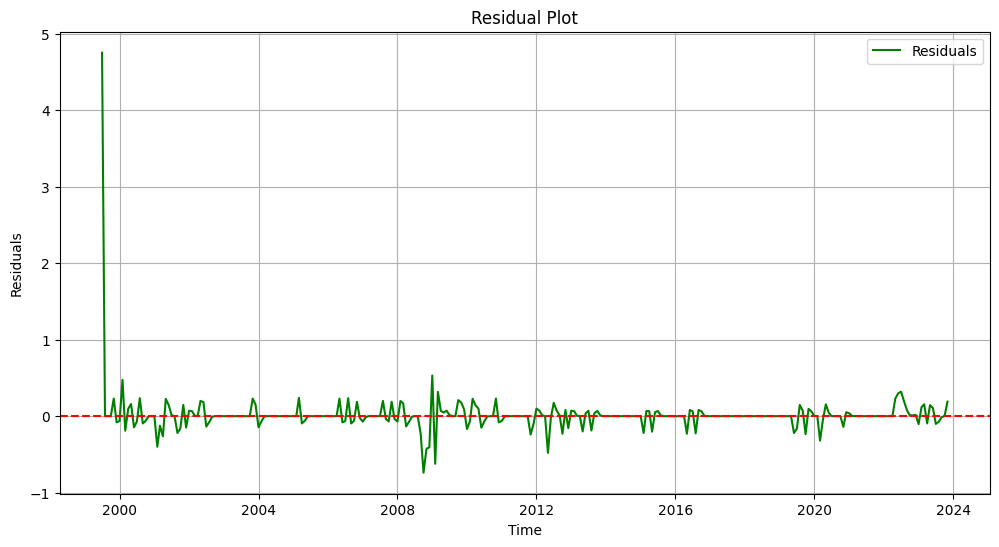

In [734]:
residuals = df['Cash_rate'] - df['predicted_cash_rate']

# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(df.index, residuals, label='Residuals', linestyle='-', color='green')  # Different color for residuals
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.legend()
plt.grid(True)
plt.show()

## XGBoost

- consider this method next time, or any other boosting methods


## Support Vector Regression (SVR)

### Intuition

- Thinking about in a $\mathbb{R}_{23}$ space (as we have 21 independent variables), using hyperplain (in a $\mathbb{R}_{22}$ space) to set various data class apart. (similar idea to the forecast point in time series analysis)
- This model allows a certian level of error terms, that within the $\textbf{Decision Boundary}$.
- SVR model aims in finding the hyperplain that best fits the data in a continuous space. That is, mapping input variables into feature space to find the hyperplain.


In [735]:
df['lag1'] = df['Cash_rate'].shift(1)
df['lag2'] = df['Cash_rate'].shift(2)
df.dropna(inplace=True)

# features and target
X = df[['lag1', 'lag2']]
y = df['Cash_rate']

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [736]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1)).ravel()

X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1)).ravel()

In [737]:
model = SVR(kernel='rbf')
model.fit(X_train_scaled, y_train_scaled)

SVR()

In [738]:
# in sample prediction
y_train_pred_scaled = model.predict(X_train_scaled)
y_train_pred = scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).ravel()

mse_in_sample = mean_squared_error(y_train, y_train_pred)
print(f'In-Sample Mean Squared Error: {mse_in_sample}')

r2_in_sample = r2_score(y_train, y_train_pred)
print(f'In-Sample R² Score: {r2_in_sample}')

In-Sample Mean Squared Error: 0.4099705773516742
In-Sample R² Score: 0.8526322271507399


In [739]:
# out of sample prediction
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

r2 = r2_score(y_test, y_pred)
print(f'R² Score: {r2}')

Mean Squared Error: 2.3122588143046743
R² Score: -0.16003369868074113


As shown, the out-of-sample prediction is pretty awful.

In [740]:
y_pred_rounded = [round_to_nearest_quarter(pred) for pred in y_pred]

mse = mean_squared_error(y_test, y_pred_rounded)
print(f'Mean Squared Error (with standardize): {mse}')

r2 = r2_score(y_test, y_pred_rounded)
print(f'R² Score (with standardize): {r2}')

Mean Squared Error (with standardize): 2.4052864406779655
R² Score (with standardize): -0.2067045907252163


In [741]:
# Ensure the correct column names are used
last_lag1 = df['lag1 cash rate'].iloc[-1]
last_lag2 = df['lag2 cash rate'].iloc[-1]

# Ensure the scaler is fitted with the correct number of features
scaler.fit(df[['lag1 cash rate', 'lag2 cash rate']])

future_predictions = []
for _ in range(5):
    new_data = scaler.transform([[last_lag1, last_lag2]])
    prediction_scaled = model.predict(new_data)[0]

    prediction = scaler.inverse_transform([[prediction_scaled, 0]])[0, 0]
    future_predictions.append(prediction)
    
    last_lag2 = last_lag1
    last_lag1 = prediction
    
future_dates = pd.date_range(start='2024-08-01', periods=6, freq='M')[1:]
future_df = pd.DataFrame({'cash rate target': future_predictions}, index=future_dates)
# future_df['cash rate target'] = future_df['cash rate target'].apply(round_to_nearest_quarter)

# Print the future predictions DataFrame to verify
print(future_df)

future_df['cash rate target'] = future_df['cash rate target'].apply(round_to_nearest_quarter)
print(future_df)

            cash rate target
2024-09-30          0.210128
2024-10-31          0.227320
2024-11-30          0.241326
2024-12-31          0.252285
2025-01-31          0.260577
            cash rate target
2024-09-30              0.15
2024-10-31              0.15
2024-11-30              0.15
2024-12-31              0.15
2025-01-31              0.15


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have va

In [742]:

# DO NOT DELETE THIS CELL

# using testing data as Predicted Data
# plt.figure(figsize=(12, 6))
# plt.plot(df.index, df['cash rate target'], label='Actual Data')
# plt.plot(df.index[train_size:], y_pred, label='Predicted Data', linestyle='--')
# plt.plot(future_df.index, future_df['cash rate target'], label='5 Steps Ahead Prediction', linestyle='--', color='red')
# plt.xlabel('Time')
# plt.ylabel('Cash Rate Target')
# plt.title('Actual vs Predicted Cash Rate Target with SVR')
# plt.legend()
# plt.show()

### plot

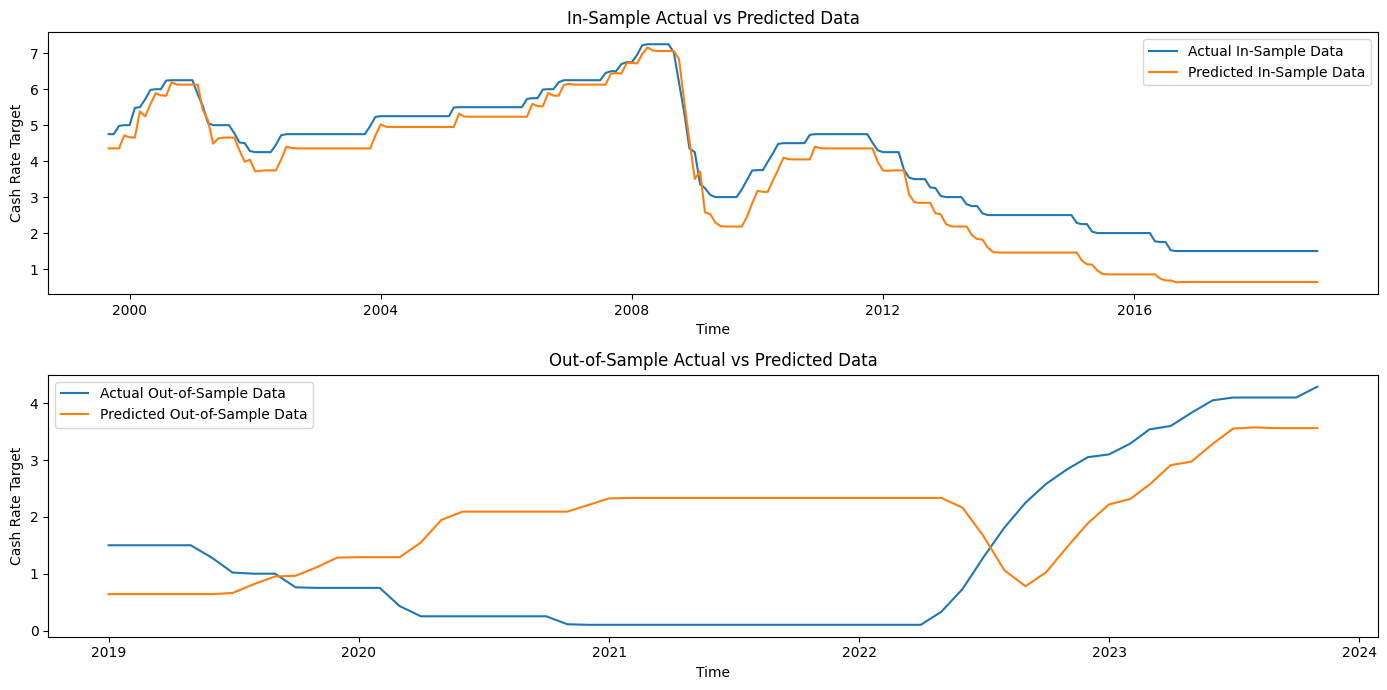

In [743]:
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(df.index[:len(y_train)], y_train, label='Actual In-Sample Data')
plt.plot(df.index[:len(y_train)], y_train_pred, label='Predicted In-Sample Data')
plt.xlabel('Time')
plt.ylabel('Cash Rate Target')
plt.legend()
plt.title('In-Sample Actual vs Predicted Data')

plt.subplot(2, 1, 2)
plt.plot(df.index[len(y_train):], y_test, label='Actual Out-of-Sample Data')
plt.plot(df.index[len(y_train):], y_pred, label='Predicted Out-of-Sample Data')
plt.xlabel('Time')
plt.ylabel('Cash Rate Target')
plt.legend()
plt.title('Out-of-Sample Actual vs Predicted Data')

plt.tight_layout()
plt.show()

In [744]:
# df['predicted_cash_rate'] = model_fit.predict_in_sample()

# mse = mean_squared_error(df['Cash_rate'], df['predicted_cash_rate'])
# print(f'Mean Squared Error: {mse}')

# residuals = df['Cash_rate'] - df['predicted_cash_rate']

# plt.figure(figsize=(12, 6))
# plt.plot(df.index, residuals, label='Residuals', linestyle='-', color='blue')
# plt.axhline(y=0, color='r', linestyle='--')
# plt.xlabel('Time')
# plt.ylabel('Residuals')
# plt.title('Residual Plot')
# plt.legend()
# plt.grid(True)
# plt.show()

In [745]:
future_df['cash rate target'] = future_df['cash rate target'].apply(round_to_nearest_quarter)
print(future_df['cash rate target'])

2024-09-30    0.15
2024-10-31    0.15
2024-11-30    0.15
2024-12-31    0.15
2025-01-31    0.15
Freq: M, Name: cash rate target, dtype: float64


As for September, the nearest target cash rate of 0.25%. In which makes nonsense. So I made some adjustments on some parameters.

### Adjustment

- from above plots we can see that predictions are higher than the actual data in most of the cases, so i use Parameter Grid to find the optimal regularization parameter, gamma and kernel (linear or polynomial or radial basis function or something else). PLus, cross-validation and grid serach, using mse as criteria.

- However, after updating the dataset, it found that this method is not as good as the above one.

In [746]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])

param_grid = {
    'svr__C': [0.1, 1, 10, 100],
    'svr__gamma': [0.001, 0.01, 0.1, 1],
    'svr__kernel': ['rbf']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f'Best parameters: {best_params}')

best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)


Best parameters: {'svr__C': 100, 'svr__gamma': 0.01, 'svr__kernel': 'rbf'}


Pipeline(steps=[('scaler', StandardScaler()), ('svr', SVR(C=100, gamma=0.01))])

In [747]:
# In-sample
y_train_pred = best_model.predict(X_train)

mse_in_sample = mean_squared_error(y_train, y_train_pred)
print(f'In-Sample Mean Squared Error: {mse_in_sample}')

r2_in_sample = r2_score(y_train, y_train_pred)
print(f'In-Sample R² Score: {r2_in_sample}')

# Out-of-sample 
y_pred = best_model.predict(X_test)

mse_out_of_sample = mean_squared_error(y_test, y_pred)
print(f'Out-of-Sample Mean Squared Error: {mse_out_of_sample}')

r2_out_of_sample = r2_score(y_test, y_pred)
print(f'Out-of-Sample R² Score: {r2_out_of_sample}')

y_test_pred = best_model.predict(X_test)

score_accuracy = r2_score(y_test, y_test_pred)
print(f'R² Score: {score_accuracy}')

In-Sample Mean Squared Error: 0.024048833731163524
In-Sample R² Score: 0.9913554209439189
Out-of-Sample Mean Squared Error: 0.03160439390966558
Out-of-Sample R² Score: 0.9841444384448731
R² Score: 0.9841444384448731


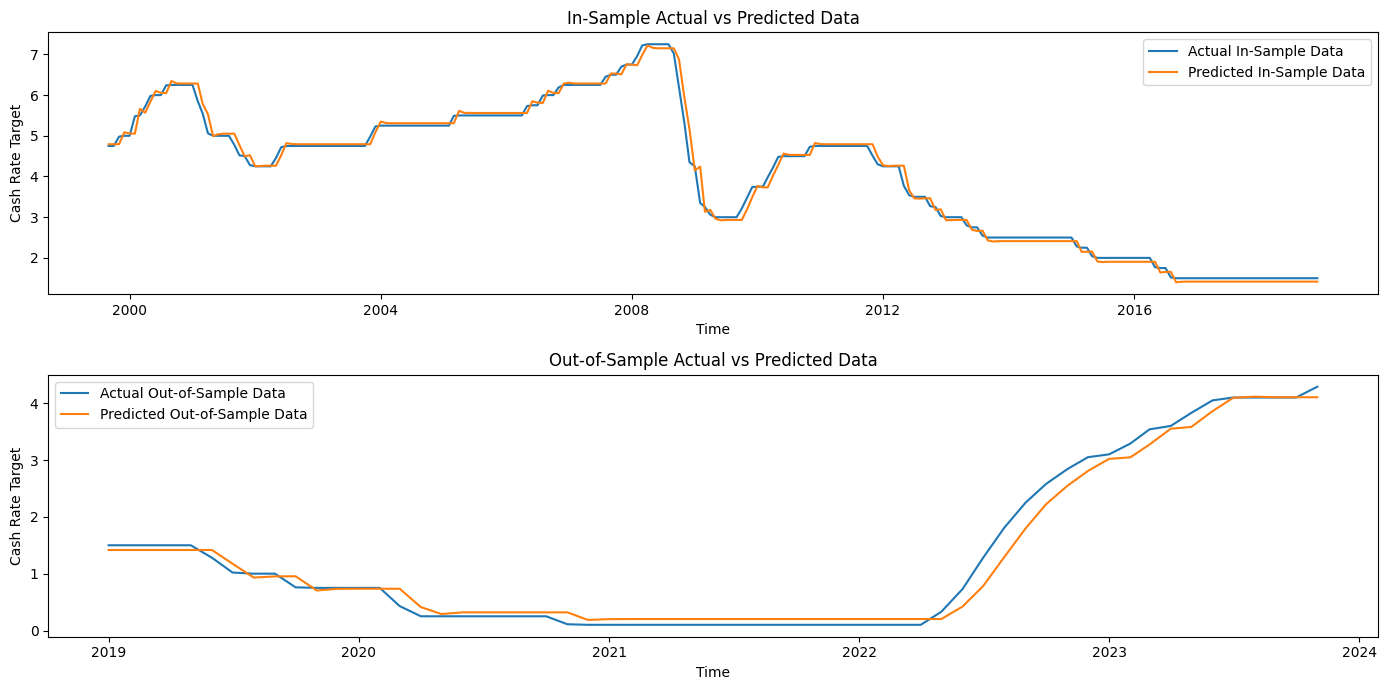

In [748]:
plt.figure(figsize=(14, 7))

# Plot in-sample predictions
plt.subplot(2, 1, 1)
plt.plot(df.index[:len(y_train)], y_train, label='Actual In-Sample Data')
plt.plot(df.index[:len(y_train)], y_train_pred, label='Predicted In-Sample Data')
plt.xlabel('Time')
plt.ylabel('Cash Rate Target')
plt.legend()
plt.title('In-Sample Actual vs Predicted Data')

# Plot out-of-sample predictions
plt.subplot(2, 1, 2)
plt.plot(df.index[len(y_train):], y_test, label='Actual Out-of-Sample Data')
plt.plot(df.index[len(y_train):], y_pred, label='Predicted Out-of-Sample Data')
plt.xlabel('Time')
plt.ylabel('Cash Rate Target')
plt.legend()
plt.title('Out-of-Sample Actual vs Predicted Data')

plt.tight_layout()
plt.show()

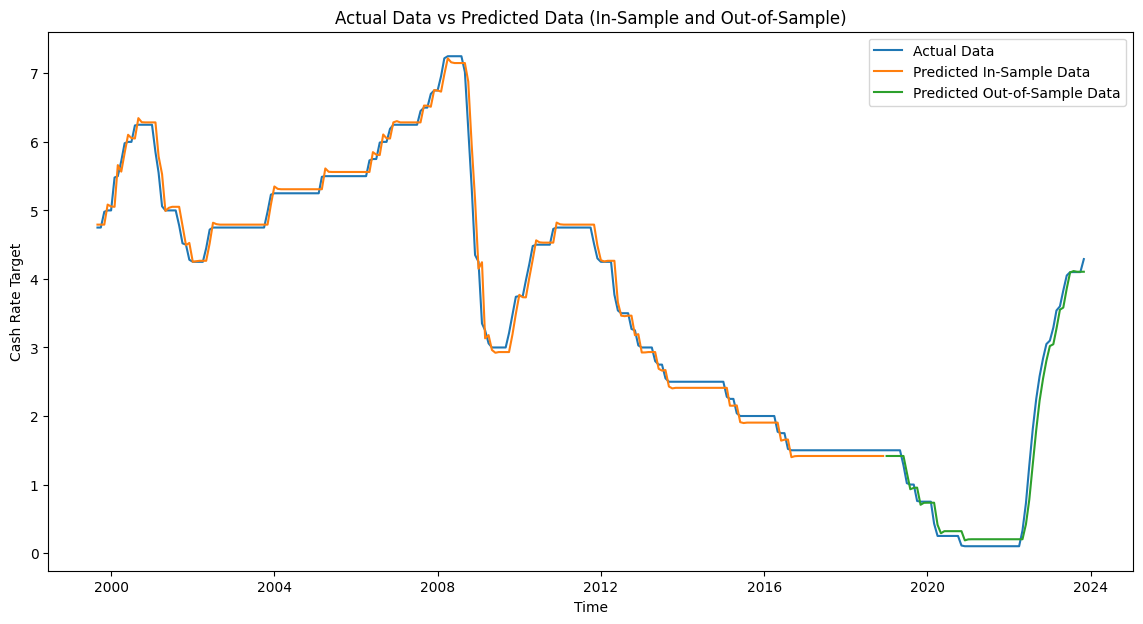

In [749]:
# combine them together
plt.figure(figsize=(14, 7))
plt.plot(df.index, y, label='Actual Data')
plt.plot(df.index[:len(y_train)], y_train_pred, label='Predicted In-Sample Data')
plt.plot(df.index[len(y_train):], y_pred, label='Predicted Out-of-Sample Data')

plt.xlabel('Time')
plt.ylabel('Cash Rate Target')
plt.legend()
plt.title('Actual Data vs Predicted Data (In-Sample and Out-of-Sample)')
plt.show()

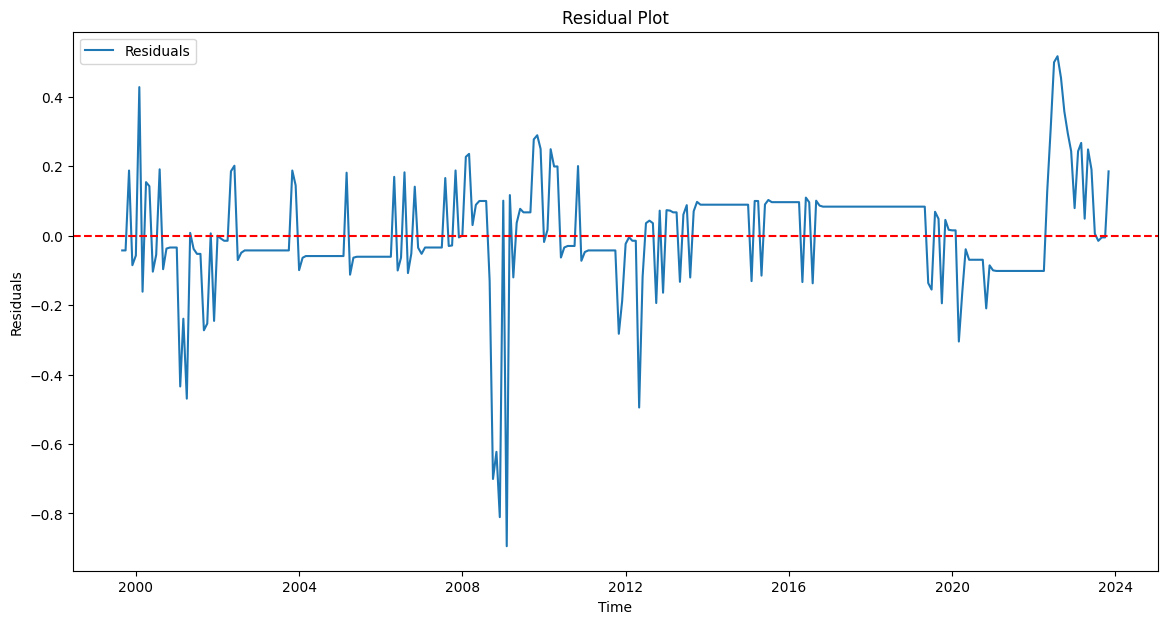

In [750]:
residuals_in_sample = y_train - y_train_pred
residuals_out_of_sample = y_test - y_pred

# Combine residuals for plotting
residuals = np.concatenate([residuals_in_sample, residuals_out_of_sample])
residuals_index = np.concatenate([df.index[:len(y_train)], df.index[len(y_train):]])

# Plot residuals
plt.figure(figsize=(14, 7))
plt.plot(residuals_index, residuals, label='Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.title('Residual Plot')
plt.show()

As shown, there's a strik after year 2008, which might because the model not able to capture or predict the regression.

### 5 steps ahead predictions

In [751]:

last_lag1 = df['lag1'].iloc[-1]
last_lag2 = df['lag2'].iloc[-1]

future_predictions = []
for _ in range(5):
    new_data = [[last_lag1, last_lag2]]
    prediction = best_model.predict(new_data)[0]
    future_predictions.append(prediction)
    
    last_lag2 = last_lag1
    last_lag1 = prediction
    
future_dates = pd.date_range(start='2024-08-01', periods=6, freq='M')[1:]
future_df = pd.DataFrame({'cash rate target': future_predictions}, index=future_dates)
print('before standardize:', future_df)
# future_df = future_df.apply(round_to_nearest_quarter)

# print('after standardize:', future_df)

before standardize:             cash rate target
2024-09-30          4.105157
2024-10-31          4.111685
2024-11-30          4.118921
2024-12-31          4.126777
2025-01-31          4.135279


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have va

The final prediction for September 2024 taget cash rate from above model is 4.10%.

* Notice that, cause taking the lag term, so there are missing data in the first and last few rows.